# Bad Sensor Identification and Homogeneous Field Correction

This section explains how Homogeneous Field Correction (HFC) is used to clean OPM data. Homogeneous Field Correction (HFC) is a preprocessing technique used to suppress artifacts that manifest as spatially uniform magnetic fields across the MEG sensor array. These unwanted signals can come from things outside the brain, like electrical equipment or background magnetic noise, and may also be caused by issues with the sensors themselves.


Brain activity produces magnetic fields that vary across different sensors because the sources are inside the brain and more focused. In contrast, noise from outside sources often creates magnetic fields that look the same everywhere—that is, they are homogeneous or uniform. HFC works by finding this uniform part of the signal and removing it. This makes the brain signals easier to see and helps reduce interference between sensors. 

Prior to applying HFC, it is important to identify and exclude any 'bad' sensors—such as those exhibiting flat signals or excessive artifacts. Including such sensors in the estimation of the homogeneous component can distort the correction and inadvertently introduce artifacts into clean channels

## Import the necessary modules
Below are the required Python modules to be imported

In [2]:
import mne
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import array
from pprint import pprint
import json
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events

## File overview

The chapter relies on the file (embedded in the BIDS structure):
```
< BIDS_ROOT >/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
```
and generates the output file
```
<BIDS_ROOT>/derivatives/preprocessing/sub-01/ses-01meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif
```




## Loading the BIDS data

#### Specify your BIDS parameters along with the BIDS folder path

In [3]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'

data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=meg_suffix, extension=meg_extension, root=bids_root)

#### Create a Derivative folder inside the BIDS Folder (Cerca_Spatt_BIDS) to save the processed data in future

In [4]:
deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=meg_suffix, root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace('meg', 'raw_hfc') # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)

#### Now Read the Raw Data

In [5]:
raw = read_raw_bids(bids_path=bids_path, verbose=False,extra_params={'preload':True})

## Idenfity the Faulty Sensors

We’ll first flag channels as “bad” in the raw dataset based on what we observed during acquisition. After that we’ll further augment the bad‐channel list by identifying additional outliers using the power spectral density estimates.

In [6]:
ch_names = raw.info['ch_names']
bad_chs = ['B4', 'H6']
bad_channels = [name for name in ch_names if any(ch in name for ch in bad_chs)]
raw.info['bads'] = bad_channels
raw.save
# Print the bad channels 
print("Bad channels marked:", raw.info['bads'])

Bad channels marked: ['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X']


Now the bad sensors will be identified based on the average power spectral density of the sensors calculated over the entire range of frequency. First the average PSD will be obtained for all the sensors and a histogram will be plotted. Sensors having high PSD value crossing a predefined threshold will be rejected and hence will not contribute towards HFC filtering. The faulty sensors will be added to the list of bad sensors identified above.

#### Compute the Power Spectral Density (PSD) of the data obtained from all the sensors.

For convenience we will here isolate the labels for the X, Y and Z directions:

In [7]:
OPMX = [item for item in raw.ch_names if item.endswith("X")]
OPMY = [item for item in raw.ch_names if item.endswith("Y")]
OPMZ = [item for item in raw.ch_names if item.endswith("Z") and not item.startswith("BNC")]

Compute PSD for each X,Y and Z Direction

In [8]:
n_fft = 1500
raw_PSDX = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMX, n_fft=n_fft, n_overlap=int(n_fft/2))
raw_PSDY = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMY, n_fft=n_fft, n_overlap=int(n_fft/2))
raw_PSDZ = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks=OPMZ, n_fft=n_fft, n_overlap=int(n_fft/2))

psdsX = raw_PSDX.get_data() # units are in T^2/Hz
freqsX = raw_PSDX.freqs 
psd_dbX = [10 * np.log10(psd * 1e30) for psd in psdsX] # Ref power: 1fT^2=1e-30T^2
average_powerX = np.mean(psd_dbX, axis=1)

psdsY = raw_PSDY.get_data() # units are in T^2/Hz
freqsY = raw_PSDY.freqs 
psd_dbY = [10 * np.log10(psd * 1e30) for psd in psdsY] # Ref power: 1fT^2=1e-30T^2
average_powerY = np.mean(psd_dbY, axis=1)

psdsZ = raw_PSDZ.get_data() # units are in T^2/Hz
freqsZ = raw_PSDZ.freqs 
psd_dbZ = [10 * np.log10(psd * 1e30) for psd in psdsZ] # Ref power: 1fT^2=1e-30T^2
average_powerZ = np.mean(psd_dbZ, axis=1)


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


#### Plot the PSD for X Direction

Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


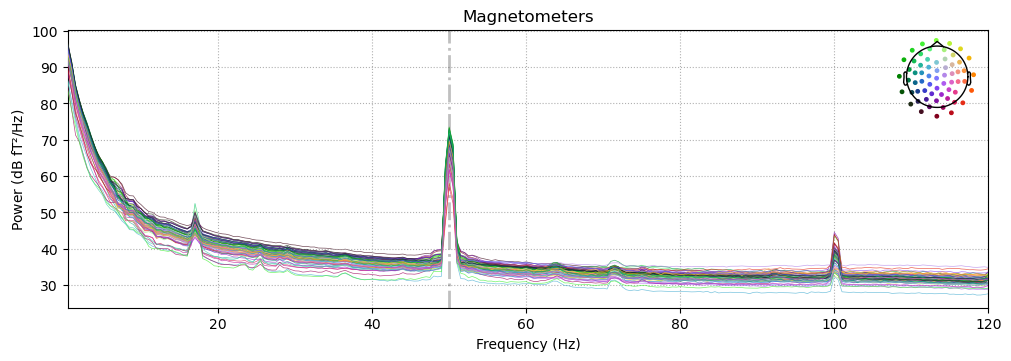

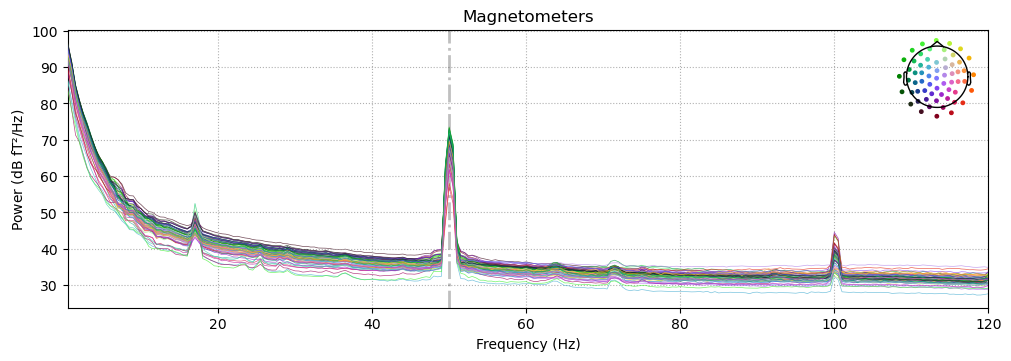

In [9]:
raw_PSDX.plot(exclude='bads')

#### Plot the PSD for Y Direction

Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


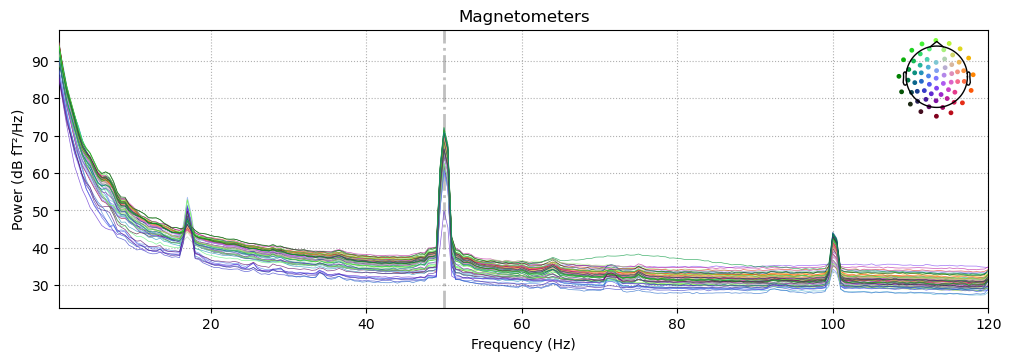

In [10]:
raw_PSDY.plot(exclude='bads')

#### Plot the PSD for Z Direction

Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


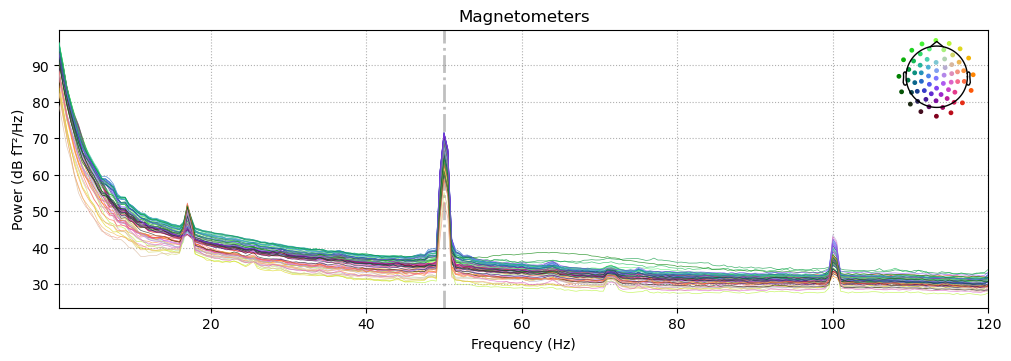

In [11]:
raw_PSDZ.plot(exclude='bads')

#### Histogram Plot

Text(0.5, 1.0, 'Histogram of Average Power Across Sensors in X Direction')

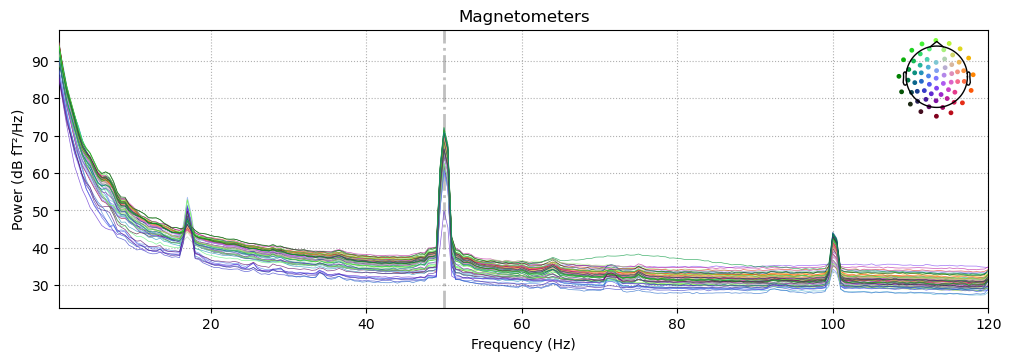

<MNELineFigure size 1000x350 with 0 Axes>

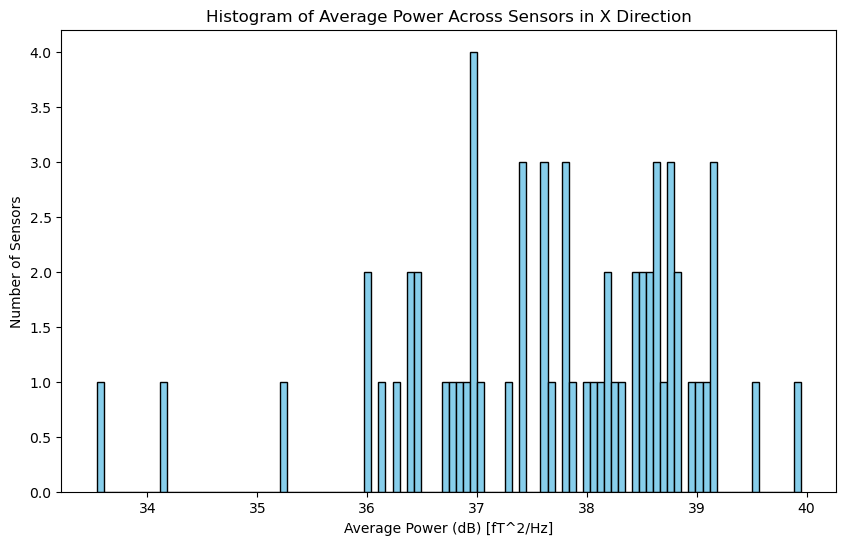

In [12]:
%matplotlib inline
plt.clf()
plt.figure(figsize=(10, 6))
plt.hist(average_powerX, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Average Power (dB) [fT^2/Hz]')
plt.ylabel('Number of Sensors')
plt.title('Histogram of Average Power Across Sensors in X Direction')

Text(0.5, 1.0, 'Histogram of Average Power Across Sensors in Y Direction')

<Figure size 640x480 with 0 Axes>

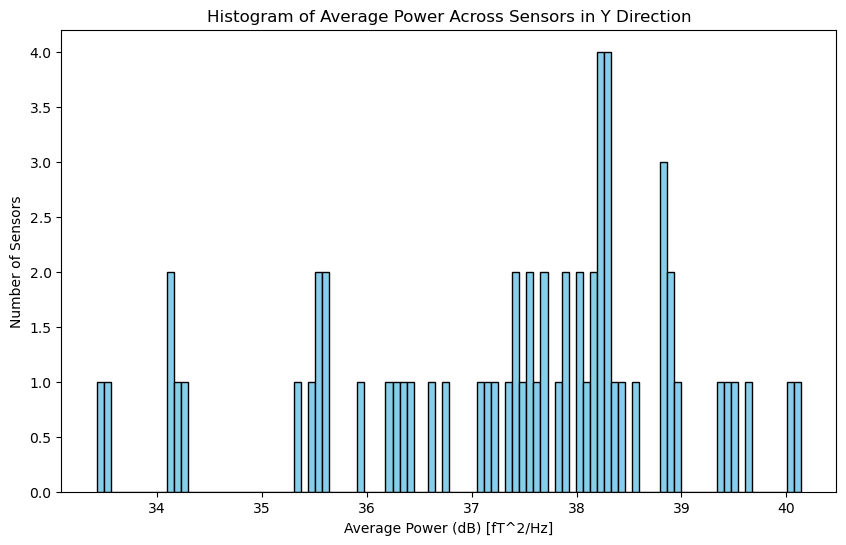

In [13]:
%matplotlib inline
plt.clf()
plt.figure(figsize=(10, 6))
plt.hist(average_powerY, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Average Power (dB) [fT^2/Hz]')
plt.ylabel('Number of Sensors')
plt.title('Histogram of Average Power Across Sensors in Y Direction')

Text(0.5, 1.0, 'Histogram of Average Power Across Sensors in Z Direction')

<Figure size 640x480 with 0 Axes>

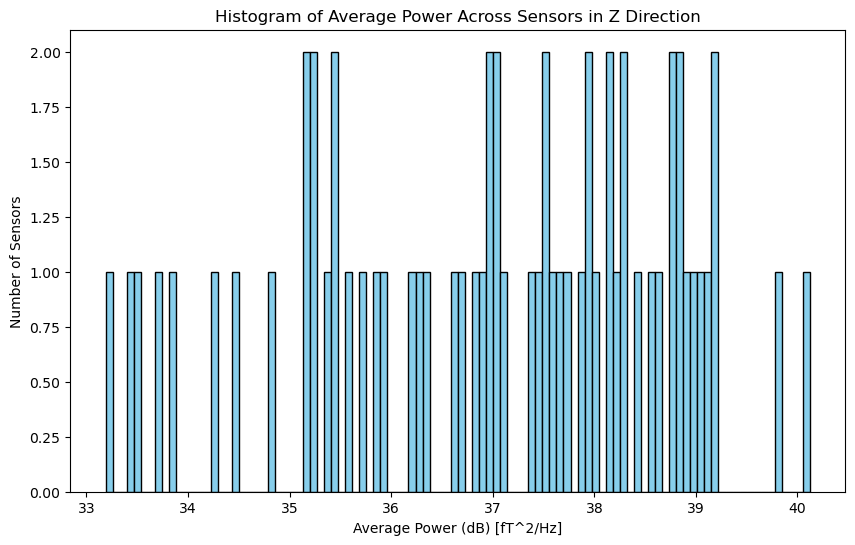

In [14]:
%matplotlib inline
plt.clf()
plt.figure(figsize=(10, 6))
plt.hist(average_powerZ, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Average Power (dB) [fT^2/Hz]')
plt.ylabel('Number of Sensors')
plt.title('Histogram of Average Power Across Sensors in Z Direction')

It is evident from the histogram that two sensors fall apart with respect to the average PSD, hence we set a cutoff at 36.2dB and the sensors beyond that will be rejected.

#### Average Power threshold

Since the sensors along the X, Y, and Z axes show different histogram patterns in terms of average power, it makes sense to use separate thresholds for each axis. A sensor is marked as bad if its power goes beyond the threshold in its respective axis. Accordingly, the thresholds are set to 39.2 dB for the X axis, 39dB for both the Y, and  39.5db for Z axes.

Here we will identify the sensors crossing the threshold defined above

In [15]:
Xsensor_names = raw_PSDX.ch_names
Ysensor_names = raw_PSDY.ch_names
Zsensor_names = raw_PSDZ.ch_names
## X Direction
Xsensors_above_threshold = [Xsensor_names[i] for i, avg in enumerate(average_powerX) if avg > 39.2]
print(Xsensors_above_threshold)

## Y Direction
Ysensors_above_threshold = [Ysensor_names[i] for i, avg in enumerate(average_powerY) if avg > 39]
print(Ysensors_above_threshold)

## Z Direction
Zsensors_above_threshold = [Zsensor_names[i] for i, avg in enumerate(average_powerZ) if avg > 39.5]
print(Zsensors_above_threshold)

['O9 G3 X', 'C8 F7 X']
['T5 C5 Y', 'T7 C8 Y', 'T11 G7 Y', 'F2 B7 Y', 'O2 H3 Y', 'O6 H1 Y']
['T1 C7 Z', 'T5 C5 Z']


#### Mark the above sensors as the bad sensors

In [16]:
raw1 = raw.copy()
new_bads = Xsensors_above_threshold + Ysensors_above_threshold + Zsensors_above_threshold
raw1.info['bads'].extend(new_bads)
print(raw1.info['bads'])

['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X', 'O9 G3 X', 'C8 F7 X', 'T5 C5 Y', 'T7 C8 Y', 'T11 G7 Y', 'F2 B7 Y', 'O2 H3 Y', 'O6 H1 Y', 'T1 C7 Z', 'T5 C5 Z']


**Question 1:** Where are the noisy sensors located? Identify and mark the sensor on the layout below:

**Question 2:** Plot the time course of a few noisy sensors and compare to non-noisy sensors. What characterizes the noisy sensors?

## Apply Homogenous Field Correction

#### Before doing HFC plot the PSD excluding the bad sensors

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


(20.0, 90.0)

<Figure size 640x480 with 0 Axes>

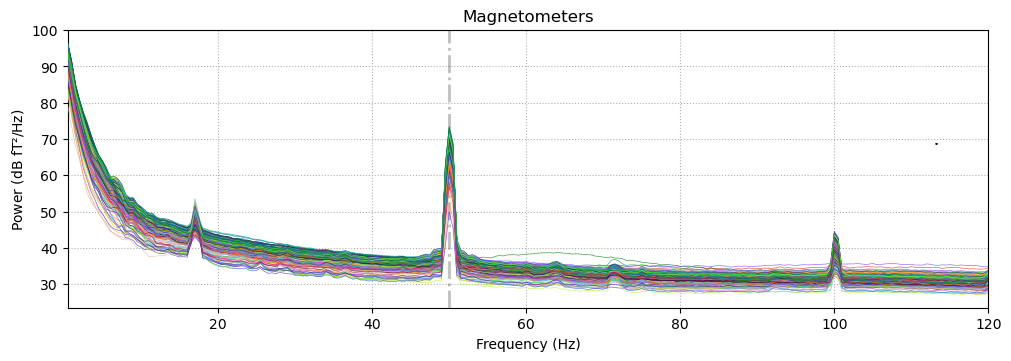

In [17]:
%matplotlib inline
plt.clf()
raw1_PSD = raw1.compute_psd(method="welch", fmin=0.1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2)).plot(exclude='bads')
plt.ylim(20, 90)

#### Plot of the raw data before pre-processing

For brevity, we will plot data from a subset of sensors, selecting every 5th sensor.

[Text(0.5, 1.0, 'Before Applying HFC'),
 (-3000.0, 3000.0),
 (0.0, 2052.6666666666665),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude (pT)')]

<Figure size 640x480 with 0 Axes>

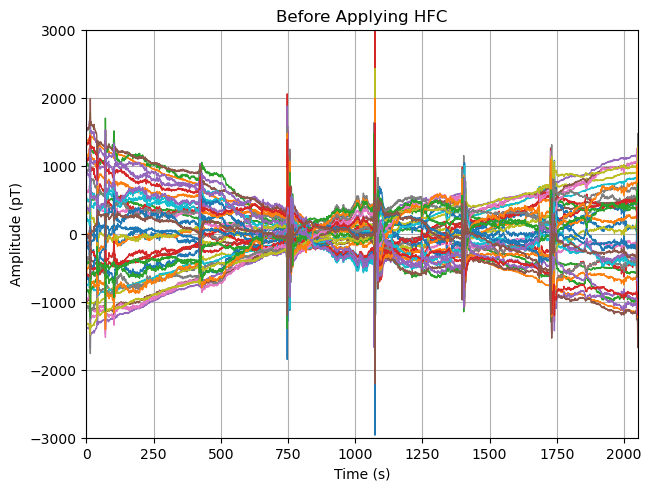

In [18]:
picks = mne.pick_types(raw1.info, meg=True,exclude='bads')

amp_scale = 1e12  # Converting to pico Tesla(pT)
stop = len(raw1.times) - 300
step = 500
data_ds, time_ds = raw1[picks[::5], :stop]
data_ds, time_ds = data_ds[:, ::step]* amp_scale , time_ds[::step]

plt.clf()
fig, ax = plt.subplots(layout="constrained")
plot_kwargs = dict(lw=1, alpha=1)
ax.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1), **plot_kwargs)
ax.grid(True)
set_kwargs = dict(
    ylim=(-3000, 3000), xlim=time_ds[[0, -1]], xlabel="Time (s)", ylabel="Amplitude (pT)"
)
ax.set(title="Before Applying HFC", **set_kwargs)

### Interference rejection using Homogeneous Field Correction

In [19]:
raw2=raw1.copy()
projs = mne.preprocessing.compute_proj_hfc(raw2.info, order=2)
raw2.add_proj(projs).apply_proj(verbose="error")

8 projection items deactivated


<Raw | sub-01_ses-01_task-SpAtt_run-01_meg.fif, 219 x 1539808 (2053.1 s), ~2.52 GiB, data loaded>

#### Plotting the raw data after applying HFC

[Text(0.5, 1.0, 'After HFC'),
 (-3000.0, 3000.0),
 (0.0, 2052.6666666666665),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude (pT)')]

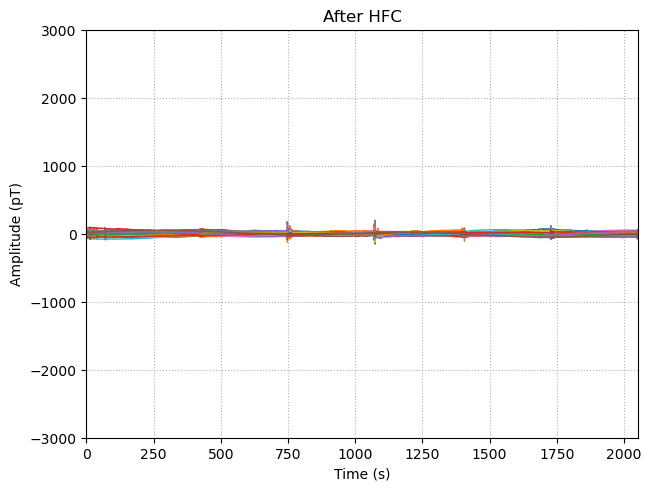

In [20]:
# plot
data_ds, _ = raw2[picks[::5], :stop]
data_ds = data_ds[:, ::step] * amp_scale

fig, ax = plt.subplots(layout="constrained")
ax.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1), **plot_kwargs)
ax.grid(True, ls=":")
ax.set(title="After HFC", **set_kwargs)

### PSD after HFC

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

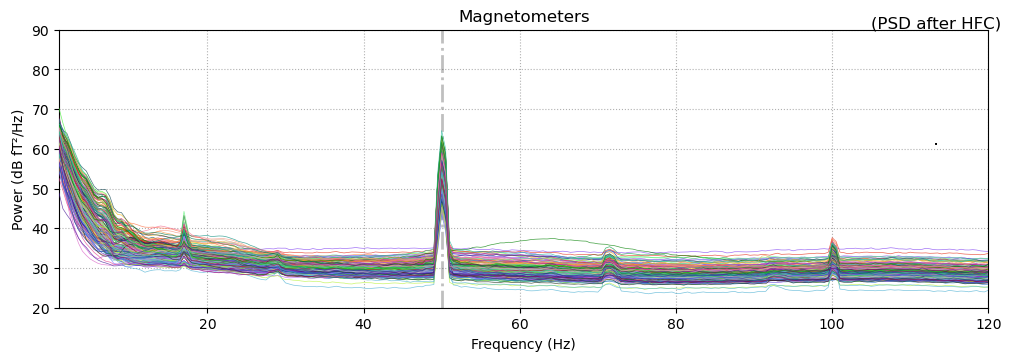

In [21]:
plt.clf()
%matplotlib inline
raw2_PSD = raw2.compute_psd(method="welch", fmin=1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2)).plot(show=False,exclude='bads')
# Add title and labels using Matplotlib
plt.title("(PSD after HFC)")
#plt.show()
for ax in raw2_PSD.axes:
    ax.set_ylim(20, 90) 
plt.show()

### Removing the other high frequency interferences using Bandpass Filter.

The data will be bandpass filtered between 0.1-120Hz.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 24751 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   25.0s


[Text(0.5, 1.0, 'After HFC and bandpass(0.1-120Hz)'),
 (-100.0, 100.0),
 (0.0, 2052.6666666666665),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude (pT)')]

<Figure size 640x480 with 0 Axes>

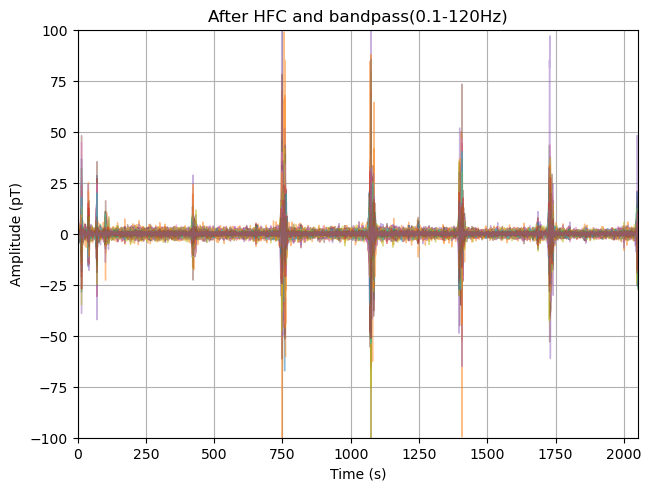

In [23]:
# notch
#raw.notch_filter(np.arange(50, 251, 50), notch_widths=4)
# bandpass
raw3=raw2.copy()
raw3.filter(0.1, 120, picks="meg")
# plot
data_ds, _ = raw3[picks[::5], :stop]
data_ds = data_ds[:, ::step] * amp_scale

plt.clf()
fig, ax = plt.subplots(layout="constrained")
plot_kwargs = dict(lw=1, alpha=0.5)
ax.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1), **plot_kwargs)
ax.grid(True)
set_kwargs = dict(
    ylim=(-100, 100), xlim=time_ds[[0, -1]], xlabel="Time (s)", ylabel="Amplitude (pT)"
)
ax.set(title="After HFC and bandpass(0.1-120Hz)", **set_kwargs)

### Calculate PSD after HFC + Filtering(0.1-120Hz)

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Text(0.5, 1.0, 'HFC+ Bandpass (0.1-120Hz)')

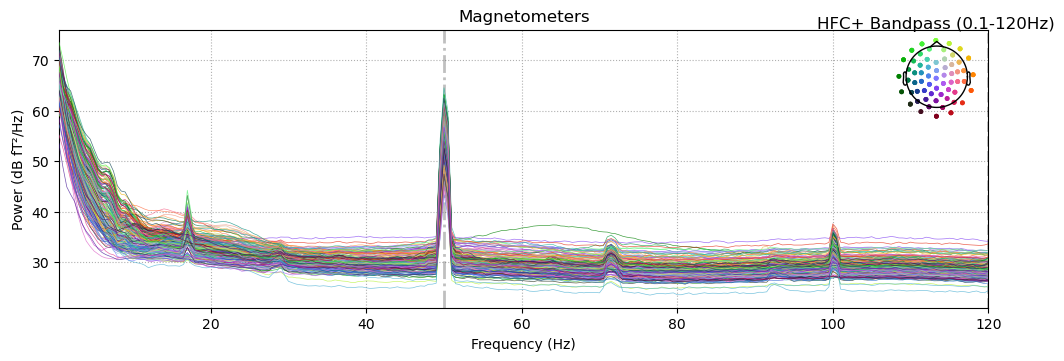

In [24]:
raw3_PSD = raw3.compute_psd(method="welch", 
                            fmin=0.1, 
                            fmax=120, 
                            picks="mag", 
                            n_fft=n_fft, 
                            n_overlap=int(n_fft/2))
raw3_PSD.plot(exclude='bads')
plt.title("HFC+ Bandpass (0.1-120Hz)")

### Indivudual Sensor PSD after HFC + Filtering (3-120Hz)

In [ ]:
n_fft = 1500
raw_PSD = raw3.compute_psd(method="welch", fmin=1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2))
psds = raw_PSD.get_data() # units are in T^2/Hz
freqs = raw_PSD.freqs 


# Convert to db
avg_psd = [10 * np.log10(psd * 1e30) for psd in psds] # Ref power: 1fT^2=1e-30T^2
average_power = np.mean(avg_psd, axis=1)
## Get Only MEG channels
mag_channels = mne.pick_types(raw3.info, meg=True, stim=False)
channel_names = [raw3.info['ch_names'][i] for i in mag_channels]

ch_power_data = list(zip(channel_names, average_power, avg_psd))
ch_power_data_s = sorted(ch_power_data, key=lambda x: x[1], reverse=True) # Sorting by average power

s_channel_names = [channel for channel, power, psd in ch_power_data_s] #Sorted Channel names
s_average_power = [power for channel, power, psd in ch_power_data_s]
s_psds = [psd for channel, power, psd in ch_power_data_s]


n_channels = len(s_channel_names)
n_cols = 4  
n_rows = 44

ymin = 20 
ymax = 70 
grand_avg_psd = np.mean(s_psds, axis=0)

plt.clf()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for rank, (channel, avg_power, psd) in enumerate(ch_power_data_s):
    ax = axes[rank]
    ax.plot(freqs, psd, label=f'{channel}')
    ax.plot(freqs, grand_avg_psd, label='Average', color='red')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power dB [fT^2/Hz]')
    avg_psd_value = np.mean(psd)
    ax.set_title(f'Rank {rank + 1}, Mean PSD: {avg_psd_value:.2f} dB')
    #ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(True)

# Delete remaining unused subplots
for ax in axes[len(s_channel_names):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

Effective window size : 2.000 (s)


<Figure size 640x480 with 0 Axes>

#### Store the filtered data within the derivatives folder of the BIDS directory.

In [18]:
raw_hfc=raw3.copy()
raw_hfc.save(deriv_file_1, overwrite=True) 

Writing C:\Users\rakshita\Downloads\Sub_OJ_new\Sub_OJ_new\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif


C:\Users\rakshita\AppData\Local\Temp\ipykernel_18808\2933808800.py:2: RuntimeWarning: This filename (C:\Users\rakshita\Downloads\Sub_OJ_new\Sub_OJ_new\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_hfc.save(deriv_file_1, overwrite=True)


Closing C:\Users\rakshita\Downloads\Sub_OJ_new\Sub_OJ_new\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif
[done]


[WindowsPath('C:/Users/rakshita/Downloads/Sub_OJ_new/Sub_OJ_new/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif')]

## Preregistration and Publication

Will update

## References

- Bezsudnova, Y., Quinn, A., & Jensen, O. (in press). *Optimizing magnetometers arrays and analysis pipelines for multivariate pattern analysis*. Journal of Neuroscience Methods.

- Hu, Y., Yin, C., Zhang, J., & Wang, Y. (2018). Partial least square aided beamforming algorithm in magnetoencephalography source imaging. *Frontiers in Neuroscience, 12*, 616. https://doi.org/10.3389/fnins.2018.00616

- Taulu, S., & Kajola, M. (2005). Presentation of electromagnetic multichannel data: the signal space separation method. *Journal of Applied Physics, 97*(12), 124905. https://doi.org/10.1063/1.1935742

- Taulu, S., & Simola, J. (2006). Spatiotemporal signal space separation method for rejecting nearby interference in MEG measurements. *Physics in Medicine and Biology, 51*(7), 1759–1768. https://doi.org/10.1088/0031-9155/51/7/008
